In [1]:
import os,sys
currentdir = os.path.dirname(os.path.abspath('./'))
parentdir = os.path.dirname(currentdir)
sys.path.append(currentdir)
import thbbanalysis.histogramming as hist
from thbbanalysis.common import tools
from thbbanalysis.common.branches import *
from thbbanalysis.common.selection import *
from thbbanalysis.histogramming.classes import *
from thbbanalysis.common.user_tools import *
from thbbanalysis.common.logger import *
import dask
import time
import glob

In [2]:
general_settings = {}
general_settings['OutDir'] = './TestDask/Output/'
general_settings['inDir']  = '/eos/user/m/maly/forPhil/tHbb_boosted_outputs_json'
general_settings['inFormat']  = 'parquet'

In [60]:
histograms = {}
histograms['ttbar'] = {}

histograms['ttbar']['nominal_Loose'] = [Hist1D('jet1_pt',  'jet1_pt', RegBinning(0,250,25), weights = 1),
                                       #  Hist1D('weight',  'weight', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight1', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight2', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight3', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight4', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight5', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight6', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight7', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight8', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight9', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight10', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight11', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight12', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight13', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight14', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight15', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight16', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight17', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight18', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight19', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight20', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight21', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight22', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight23', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight24', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight25', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight26', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight27', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight28', RegBinning(0,250,25), weights = 1),
                                       # Hist1D('weight',  'weight29', RegBinning(0,250,25), weights = 1),
                                       Hist1D('jets_pt',  'jets_pt', RegBinning(0,250,25), weights = 1),]


mainman = histograms['ttbar']['nominal_Loose'][0]
mainma2 = histograms['ttbar']['nominal_Loose'][1]
for i in range(20):
    histograms['ttbar']['nominal_Loose'].append(Hist1D(mainman.var, mainman.name+f'_{i}', mainman.binning))

for i in range(20):
    histograms['ttbar']['nominal_Loose'].append(Hist1D(mainma2.var, mainma2.name+f'_{i}', mainma2.binning))


In [61]:
from copy import copy
def get_inputs(sample: str):
    '''
    Method to get a list of files to read in. This assumes all files
    are named sample_chunk*
    Args:
        cfg: Config object carrying all info provided by user in config file
        sample: Name of the sample being processed
    Return
        files: A list of files to read
    '''
    indirs = [general_settings['inDir']]
    ext = general_settings['inFormat']
    files = [infile for indir in indirs for infile in glob.glob(f"{indir}/{sample}_chunk*{ext}")]
    if len(files) == 0:
        logger.error(f"No files for sample {sample} were found in specified directories {indirs}")
    return files

def get_new_br_info(new_branches):
    import inspect
    return [{'write_name': br.write_name, 'alg_args': br.alg_args,
             'alg_arg_types': br.alg_arg_types, 'alg': copy_func(br.alg)} 
              for br in new_branches]
    
import types

def copy_func(f, name=None):
    '''
    return a function with same code, globals, defaults, closure, and 
    name (or provide a new name)
    '''
    fn = types.FunctionType(f.__code__, f.__globals__, name or f.__name__,
        f.__defaults__, f.__closure__)
    # in case f was given attrs (note this dict is a shallow copy):
    fn.__dict__.update(f.__dict__) 
    return fn

@dask.delayed
def apply_cuts(init_data, sel):
    logger = ColoredLogger()
    data = copy(init_data)
    if sel is not None:
        args = sel.args
        cuts = sel.func
        args = [data[arg] if isinstance(arg,str) else arg for arg in args]
        data = data[cuts(*args)]
        if len(data) != 0: # if we haven't filtered out all data
            return data
        else:
            logger.warning(f"Selection for object cuts all data, padding zeroes")
            data = ak.zeros_like(data)
            return data
    else:
        return data

@dask.delayed
def create_new_branches(akdata: "ak.Array", new_branches,):
    logger = ColoredLogger()
    '''
    Method to create new branches from input, or from other new branches
    Args: 
        data: Awkward array with data from a tree in one input file (one sample chunk)
        new_branches: A map of new branches for one sample-tree combo 
    Return:
        data: Awkward array with data including newly calculated branches
    '''
    data = {}
    for field in akdata.fields:
        data[field] = akdata[field]

    new_branches_from_others: List["Branch"] = [] 
    for branch in new_branches:
        # if we need other new branches to compute this new branch, save it for later
        if len(set([br["write_name"] for br in new_branches]).intersection(set(branch["alg_args"])))!=0:
            new_branches_from_others.append(branch)
            continue
        try:
            # Get args and execute the new beanch algo
            args = [data[arg] if branch["alg_arg_types"][i] == Branch else arg for i, arg in enumerate(branch["alg_args"])]
            data[branch["write_name"]] = branch["alg"](*args)
        except KeyError as missing_branch:
            for i, arg in enumerate(branch["alg_args"]):
                if branch["alg_arg_types"][i] == Branch:
                    if arg not in data.fields:
                        logger.error("Branch {arg} not found in data or other new branches.")
    # If we have any branches that are saved for later proessing, 
    # re-run the method on them with the updated data containing new branches
    if(len(new_branches_from_others)!=0):
        data = create_new_branches(data, new_branches_from_others)
    return data

@dask.delayed
def fill_hists(data, var, weight, axis):
    h =  bh.Histogram(axis, storage=bh.storage.Weight())
    var_data = data[var]
    weights = weight
    # If var_data processed is an awkward array, turn to numpy
    var_data = var_data.to_numpy()
    #weights = weights.to_numpy()
    weights = np.ma.masked_where(np.ma.getmask(var_data), weights)
    #var_data= var_data.compressed()
    #weights = weights.compressed()
    # Fill the boost histogram
    h.fill(var_data)
    return h

In [64]:
from dask.distributed import Client
client = Client(n_workers = 4, threads_per_worker = 2)  # start distributed scheduler locally.
client

[numexpr.utils:INFO]  Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils:INFO]  NumExpr defaulting to 8 threads.
[bokeh.server.util:WARNING]  Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly
2022-04-26 20:12:27,868 - bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly
[bokeh.server.tornado:INFO]  Keep-alive ping configured every 500 milliseconds
[bokeh.server.tornado:INFO]  Check for unused sessions every 500 milliseconds
[bokeh.server.tornado:INFO]  User authentication hooks NOT provided (default user enabled)
[distributed.scheduler:INFO]  Clear task state
[distributed.scheduler:INFO]    Scheduler at:     tcp://127.0.0.1:46501
[distributed.scheduler:INFO]    dashboard at:            127

<Client: 'tcp://127.0.0.1:46501' processes=4 threads=8, memory=28.60 GiB>

[bokeh.server.views.ws:INFO]  WebSocket connection opened
[bokeh.server.views.ws:INFO]  ServerConnection created


In [65]:
%%time

def pls(jets_pt):
    jets_pt = mask(jets_pt, count_jagged(jets_pt, axis=1)>=1)
    return jets_pt[:, 0]*1e-3
def pls2(jets_pt):
    return ak.ravel(jets_pt)*1e-3


new_branches = {}
nl_branches = {'nominal_Loose': [Branch("jet1_pt", pls, args = ['jet_pt'], args_types=[Branch]),
                                 Branch("jets_pt", pls2, args = ['jet_pt'], args_types=[Branch])]}
new_branches['ttbar'] = nl_branches


## Slow transfer of data across workers if we try to fill same histogram from different files in the next batches.
## Make a new histogram everytime, fill partly, then combine at the end outside of dask


for sample, tree_to_hists in histograms.items():
    for tree, objs in tree_to_hists.items():
        new_br_list = new_branches[sample][tree]
        new_brs = get_new_br_info(new_br_list)
        
        files = get_inputs(sample) # get_inputs(sample)[:2] to run for consistency check
        batch_size = 4
        # objs = objs[:1] to run for consistency check
        # add metadata like extension to tools ...
        hm = HistManager(objs, files, batch_size, new_brs, tree, sample)
        results = hm.get_tasks()
        




[classes:INFO]  Reading in data from file 1/19 ...
[classes:INFO]  Creating new branches in data from file 1/19 ...
[classes:INFO]  Reading in data from file 2/19 ...
[classes:INFO]  Creating new branches in data from file 2/19 ...
[classes:INFO]  Reading in data from file 3/19 ...
[classes:INFO]  Creating new branches in data from file 3/19 ...
[classes:INFO]  Reading in data from file 4/19 ...
[classes:INFO]  Creating new branches in data from file 4/19 ...
[classes:INFO]  Reading in data from file 5/19 ...
[classes:INFO]  Creating new branches in data from file 5/19 ...
[classes:INFO]  Reading in data from file 6/19 ...
[classes:INFO]  Creating new branches in data from file 6/19 ...
[classes:INFO]  Reading in data from file 7/19 ...
[classes:INFO]  Creating new branches in data from file 7/19 ...
[classes:INFO]  Reading in data from file 8/19 ...
[classes:INFO]  Creating new branches in data from file 8/19 ...
[classes:INFO]  Reading in data from file 9/19 ...
[classes:INFO]  Creat

CPU times: user 462 ms, sys: 99.6 ms, total: 562 ms
Wall time: 534 ms


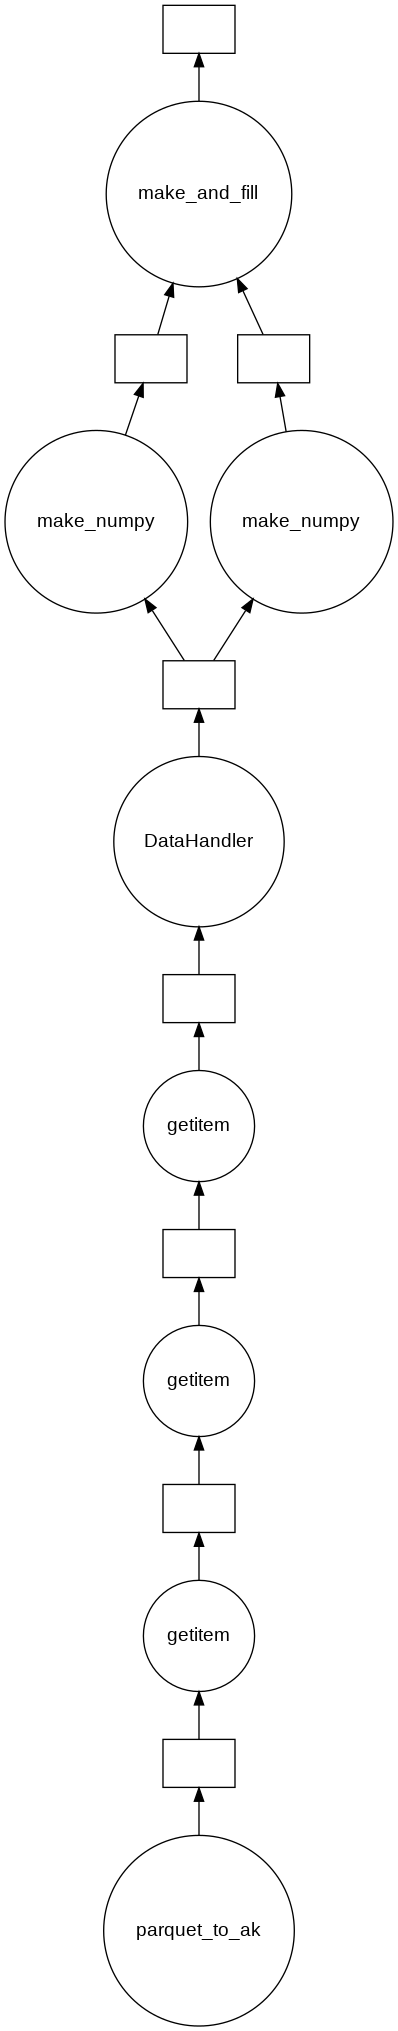

In [6]:
dask.visualize(results[0][0])

In [68]:
%%time
computed = []
for res in results:
    computed.extend(dask.compute(*res))

CPU times: user 7.53 s, sys: 406 ms, total: 7.93 s
Wall time: 16.6 s


In [59]:
%time 
hists = hm.combine_hists(computed)
print(hists['jets_pt'])

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs
                    ┌────────────────────────────────────────────────────────┐
[-inf,   0) 0       │                                                        │
[   0,  10) 0       │                                                        │
[  10,  20) 0       │                                                        │
[  20,  30) 8140353 │███████████████████████████████████████████████████████ │
[  30,  40) 5754565 │██████████████████████████████████████▉                 │
[  40,  50) 4724961 │███████████████████████████████▉                        │
[  50,  60) 4083510 │███████████████████████████▋                            │
[  60,  70) 3625289 │████████████████████████▌                               │
[  70,  80) 3102035 │█████████████████████                                   │
[  80,  90) 2608920 │█████████████████▋                                      │
[  90, 100) 2157928 │██████████████▋                                 

Now we can test the equivalent code with sequential processing. To check consistency of results, run over 2 files and 1 histogram 

In [31]:
from copy import copy
def get_inputs(sample: str):
    '''
    Method to get a list of files to read in. This assumes all files
    are named sample_chunk*
    Args:
        cfg: Config object carrying all info provided by user in config file
        sample: Name of the sample being processed
    Return
        files: A list of files to read
    '''
    indirs = [general_settings['inDir']]
    ext = general_settings['inFormat']
    files = [infile for indir in indirs for infile in glob.glob(f"{indir}/{sample}_chunk*{ext}")]
    if len(files) == 0:
        logger.error(f"No files for sample {sample} were found in specified directories {indirs}")
    return files

def get_new_br_info(new_branches):
    import inspect
    return [{'write_name': br.write_name, 'alg_args': br.alg_args,
             'alg_arg_types': br.alg_arg_types, 'alg': copy_func(br.alg)} 
              for br in new_branches]
    
import types

def copy_func(f, name=None):
    '''
    return a function with same code, globals, defaults, closure, and 
    name (or provide a new name)
    '''
    fn = types.FunctionType(f.__code__, f.__globals__, name or f.__name__,
        f.__defaults__, f.__closure__)
    # in case f was given attrs (note this dict is a shallow copy):
    fn.__dict__.update(f.__dict__) 
    return fn

def apply_cuts(init_data, sel):
    logger = ColoredLogger()
    data = copy(init_data)
    if sel is not None:
        args = sel.args
        cuts = sel.func
        args = [data[arg] if isinstance(arg,str) else arg for arg in args]
        data = data[cuts(*args)]
        if len(data) != 0: # if we haven't filtered out all data
            return data
        else:
            logger.warning(f"Selection for object cuts all data, padding zeroes")
            data = ak.zeros_like(data)
            return data
    else:
        return data

def create_new_branches(init_data: "ak.Array", xx):
    data = copy(init_data)
    '''
    Method to create new branches from input, or from other new branches
    Args: 
        data: Awkward array with data from a tree in one input file (one sample chunk)
        new_branches: A map of new branches for one sample-tree combo 
    Return:
        data: Awkward array with data including newly calculated branches
    '''
    new_branches_from_others: List["Branch"] = [] 
    for branch in xx:
        # if we need other new branches to compute this new branch, save it for later
        if len(set([br["write_name"] for br in xx]).intersection(set(branch["alg_args"])))!=0:
            new_branches_from_others.append(branch)
            continue
        try:
            # Get args and execute the new beanch algo
            args = [data[arg] if branch["alg_arg_types"][i] == Branch else arg for i, arg in enumerate(branch["alg_args"])]
            data[branch["write_name"]] = branch["alg"](*args)
        except KeyError as missing_branch:
            for i, arg in enumerate(branch["alg_args"]):
                if branch["alg_arg_types"][i] == Branch:
                    if arg not in data.fields:
                        exit(1)
                        #pass
    # If we have any branches that are saved for later proessing, 
    # re-run the method on them with the updated data containing new branches
    if(len(new_branches_from_others)!=0):
        data = create_new_branches(data, new_branches_from_others)
    return data

def fill_hists(data, var, weight, axis):
    h =  bh.Histogram(axis, storage=bh.storage.Weight())
    var_data = data[var]
    weights = weight
    # If var_data processed is an awkward array, turn to numpy
    var_data = var_data.to_numpy()
    #weights = weights.to_numpy()
    weights = np.ma.masked_where(np.ma.getmask(var_data), weights)
    #var_data= var_data.compressed()
    #weights = weights.compressed()
    # Fill the boost histogram
    h.fill(var_data)
    return h

In [35]:
%%time

def pls(jets_pt):
    jets_pt = mask(jets_pt, count_jagged(jets_pt, axis=1)>=1)
    return jets_pt[:, 0]*1e-3
new_branches = {}
nl_branches = {'nominal_Loose': [Branch("jet1_pt", pls, args = ['jet_pt'], args_types=[Branch]),]}
new_branches['ttbar'] = nl_branches


## Slow transfer of data across workers if we try to fill same histogram from different files in the next batches.
## Make a new histogram everytime, fill partly, then combine at the end outside of dask


for sample, tree_to_hists in histograms.items():
    for tree, objs in tree_to_hists.items():

        files = get_inputs(sample) # get_inputs(sample)[:2] to run for consistency check
        results = []
        batch_size = 4
        for i in range(0, len(files), batch_size):
            batch_results = []
            for j, file in enumerate(files[i:i+batch_size]):
                logger.info(f"Reading in data from file {i+j+1}/{len(files)} ...")
                data = tools.parquet_to_ak(file)[0][sample][tree]
                logger.info(f"Creating new branches in data from file {i+j+1}/{len(files)} ...")
                new_br_list = new_branches[sample][tree]
                new_br = get_new_br_info(new_br_list)
                data = create_new_branches(data, new_br)
                # objs = objs[:1] to run for consistency check
                for obj in objs:
                    new_data = data
                    if i == 0:
                        obj.make_hist()
                    #batch_results.append(fill_hists(new_data, ob_info["var"], ob_info["weights"], ob_info["axis"]))
                    batch_results.append(obj.nd_fill_hist(new_data))
            results.append(batch_results)
            
            

print(results[0][0]+results[0][1])

[<timed exec>:INFO]  Reading in data from file 1/2 ...
[<timed exec>:INFO]  Creating new branches in data from file 1/2 ...
[<timed exec>:INFO]  Reading in data from file 2/2 ...
[<timed exec>:INFO]  Creating new branches in data from file 2/2 ...


                   ┌─────────────────────────────────────────────────────────┐
[-inf,   0) 0      │                                                         │
[   0,  10) 648    │▏                                                        │
[  10,  20) 0      │                                                         │
[  20,  30) 4458   │█▎                                                       │
[  30,  40) 18914  │█████▎                                                   │
[  40,  50) 57354  │███████████████▉                                         │
[  50,  60) 116368 │████████████████████████████████▎                        │
[  60,  70) 174066 │████████████████████████████████████████████████▏        │
[  70,  80) 202454 │████████████████████████████████████████████████████████ │
[  80,  90) 202248 │████████████████████████████████████████████████████████ │
[  90, 100) 185756 │███████████████████████████████████████████████████▍     │
[ 100, 110) 161720 │████████████████████████████████